In [46]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import RobustScaler,PowerTransformer
import lightgbm as lgb

In [47]:
from sklearn.mixture import GaussianMixture
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans

In [48]:
df = pd.read_csv('data/Gia SMP va SMPcap 2021(Giá thị trường SMP).csv', encoding="latin-1", delimiter=';')
df.head()

,Ngày,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,01/01/2021,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,...,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4,964.4
1,01/02/2021,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,...,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7,1019.7
2,01/03/2021,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,...,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4,988.4
3,01/04/2021,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.0,1002.1,...,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8,1010.8
4,01/05/2021,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,...,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5,1061.5


In [49]:
msv = 2151260835
col = msv%12 + 1

In [50]:
data = df[[str(col)]]
data

,4
0,964.4
1,1019.7
2,988.4
3,1002.0
4,1061.5
...,...
360,1002.0
361,1002.0
362,1061.5
363,1022.6


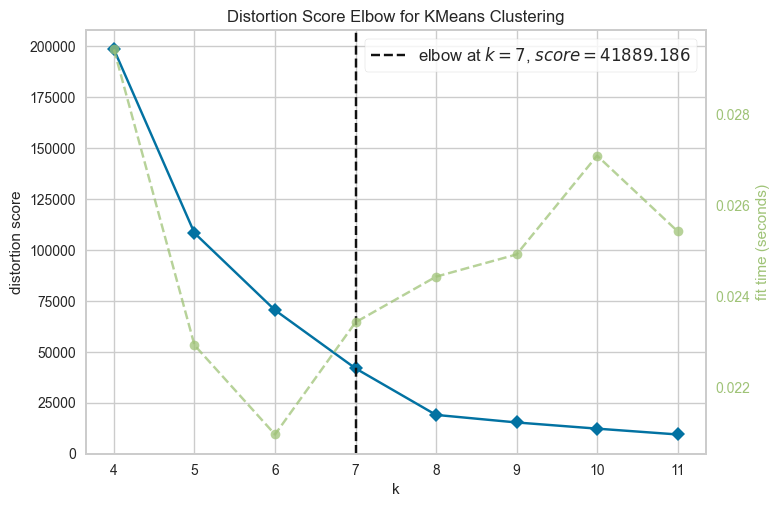

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [51]:
Elbow_M = KElbowVisualizer(KMeans(random_state=23, n_init=10), k=(4,12))
Elbow_M.fit(data)
Elbow_M.show()

In [52]:
BGM = BayesianGaussianMixture(n_components=8,covariance_type='full',random_state=1,n_init=15)
# fit model and predict clusters
preds = BGM.fit_predict(data)

In [53]:
pp=BGM.predict_proba(data)# Calcualting the probabilities of each prediction
df_new=pd.DataFrame(data) 
df_new[[f'predict_proba_{i}' for i in range(8)]]=pp # creating new dataframe columns of probabilites 
df_new['preds']=preds
df_new['predict_proba']=np.max(pp,axis=1)
df_new['predict']=np.argmax(pp,axis=1)
    
train_index=np.array([])
for n in range(8):
    n_inx=df_new[(df_new.preds==n) & (df_new.predict_proba > 0.68)].index
    train_index = np.concatenate((train_index, n_inx))

In [54]:
from sklearn.model_selection import StratifiedKFold
X_new=df_new.loc[train_index]
y=df_new.loc[train_index]['preds']

params_lgb = {'learning_rate': 0.06,'objective': 'multiclass','boosting': 'gbdt','n_jobs': -1,'verbosity': -1, 'num_classes':8} 

model_list=[]

gkf = StratifiedKFold(11)
for fold, (train_idx, valid_idx) in enumerate(gkf.split(X_new,y)):   

    tr_dataset = lgb.Dataset(X_new.iloc[train_idx],y.iloc[train_idx])
    vl_dataset = lgb.Dataset(X_new.iloc[valid_idx],y.iloc[valid_idx])
    
    model = lgb.train(params = params_lgb, 
                train_set = tr_dataset, 
                valid_sets =  vl_dataset, 
                num_boost_round = 5000, 
                callbacks=[ lgb.early_stopping(stopping_rounds=400, verbose=False), lgb.log_evaluation(period=200)])  
    
    model_list.append(model) 

[200]	valid_0's multi_logloss: 6.41407e-06
[400]	valid_0's multi_logloss: 6.41407e-06
[200]	valid_0's multi_logloss: 6.28823e-06
[400]	valid_0's multi_logloss: 6.28823e-06
[200]	valid_0's multi_logloss: 6.39422e-06
[400]	valid_0's multi_logloss: 6.39422e-06
[200]	valid_0's multi_logloss: 6.39422e-06
[400]	valid_0's multi_logloss: 6.39422e-06
[200]	valid_0's multi_logloss: 6.39422e-06
[400]	valid_0's multi_logloss: 6.39422e-06
[200]	valid_0's multi_logloss: 6.39422e-06
[400]	valid_0's multi_logloss: 6.39422e-06
[200]	valid_0's multi_logloss: 6.26776e-06
[400]	valid_0's multi_logloss: 6.26776e-06
[200]	valid_0's multi_logloss: 6.84467e-06
[400]	valid_0's multi_logloss: 6.84467e-06
[200]	valid_0's multi_logloss: 6.46594e-06
[400]	valid_0's multi_logloss: 6.46594e-06
[200]	valid_0's multi_logloss: 6.46594e-06
[400]	valid_0's multi_logloss: 6.46594e-06
[200]	valid_0's multi_logloss: 6.46594e-06
[400]	valid_0's multi_logloss: 6.46594e-06


In [55]:
lgb_preds=0
for model in model_list:
    lgb_preds+=model.predict(df_new)

In [56]:
labels=np.argmax(lgb_preds,axis=1)

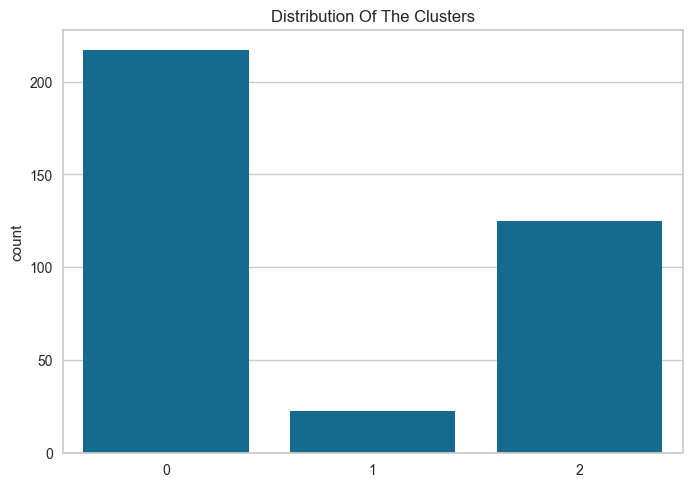

In [57]:
pl = sns.countplot(x=np.argmax(lgb_preds,axis=1))
pl.set_title("Distribution Of The Clusters")
plt.show()

TypeError: Axes3D.scatter() missing 1 required positional argument: 'ys'

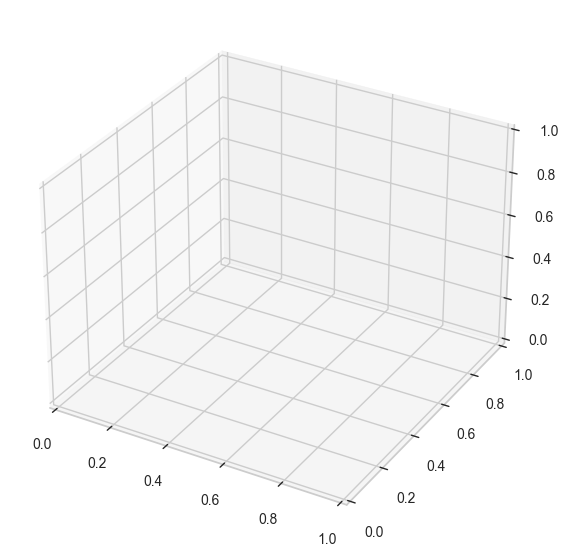

In [61]:
fig = plt.figure(figsize=(15,8))
ax = plt.subplot(1,2,1, projection='3d', label="bla")
ax.scatter(data, s=40, marker='o', cmap = 'rainbow' )
ax.set_title("Before clustering")
ax = plt.subplot(1,2,2, projection='3d', label="bla")
ax.scatter(data, s=40, c=data["Clusters"], marker='o',cmap="rainbow")
ax.set_title("After Clustering")
plt.show()

In [62]:
ss.Predicted=np.argmax(lgb_preds,axis=1)

NameError: name 'ss' is not defined

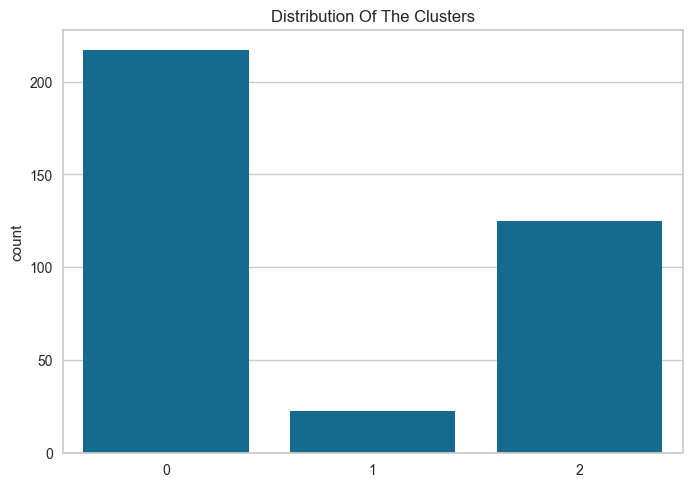

In [63]:
pl = sns.countplot(x=np.argmax(lgb_preds,axis=1))
pl.set_title("Distribution Of The Clusters")
plt.show()